# Setup

In [1]:
%cd ..

/home/pdona/VariousExercises/SentimentAnalysisAmazonMerchant


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from ProductReviewScraper.models import Review, Product
import ProductReviewScraper.amazon_review_database as db

# Load data from datatabase

In [4]:
df = pd.read_sql(
    db.session.query(
        Product, Review).filter(Review.product_id == Product.id).statement,
    con=db.engine
)

df.drop(['id', 'id_1', 'product_id'],
        axis='columns', inplace=True)
df.columns = ['product_asin', 'product_name',  'product_imageurl',
              'product_price', 'product_global_rating', 'review_amazonid',
              'review_user', 'review_rating', 'review_title',
              'review_date', 'review_verified', 'review_foreign',
              'review_content', 'review_helpful_vote']
dftmp = df.copy()
df = None

We keep only reviews written in english and we drop automatic translations

In [5]:
df = dftmp[dftmp["review_foreign"] == False].copy()
df.drop(['review_foreign'],
        axis='columns', inplace=True)


There is a strange cap at 5K reviews - To investigate. 
The products are alla more or less the same and they are priced in a 15$ window. 
It make sense to analyze them as a group.

# Basic EDA

The reviews are scraped from Amazon.com therefore are US centric. Keep it in mind.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61294 entries, 0 to 63616
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_asin           61294 non-null  object 
 1   product_name           61294 non-null  object 
 2   product_imageurl       61294 non-null  object 
 3   product_price          61294 non-null  float64
 4   product_global_rating  61294 non-null  int64  
 5   review_amazonid        61294 non-null  object 
 6   review_user            61294 non-null  object 
 7   review_rating          61294 non-null  int64  
 8   review_title           61294 non-null  object 
 9   review_date            61294 non-null  object 
 10  review_verified        61294 non-null  bool   
 11  review_content         61294 non-null  object 
 12  review_helpful_vote    61294 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(8)
memory usage: 6.1+ MB


There are no missing data. We scraped the reviews carefully.

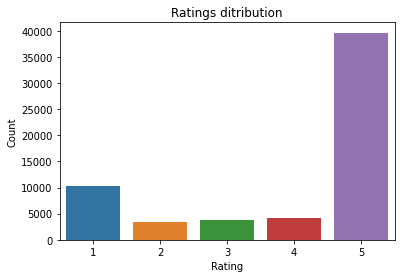

In [7]:
ax = sns.countplot(data=df, x="review_rating")
ax.set(title="Ratings ditribution", xlabel="Rating", ylabel="Count");


The global (cumulative) rating distribution is typical of amazon products. There is a large excess of positive ratings. The reviews are often polarized (1 and 5 are preferred).

In [8]:
df["product_asin"].unique()

array(['B000X457HO', 'B08TZ75LLK', 'B000WQY7RO', 'B000WUFVR0',
       'B004G9C0SQ', 'B000JDGC78', 'B001L2MD2E', 'B001U40C6W',
       'B000W3V8S8', 'B004TAY2Q0', 'B07F7TWGGC', 'B07Y92C59V',
       'B000TVJ6XW', 'B000WQZ5PC', 'B000P6THK8', 'B006QOK0ZY',
       'B004G9DV66', 'B01N68CWKV', 'B001D6HB0M', 'B07144XJDK',
       'B003U24B7S', 'B06X6H95GW', 'B0002PW0WO', 'B01MTS599T'],
      dtype=object)

In [9]:
df["product_name"].unique()


array(['Yankee Candle Large Jar Candle Vanilla Cupcake',
       'Yankee Candle Vanilla Crème Brulée Signature Large Tumbler Candle, Large 2-Wick Tumbler',
       'Yankee Candle Large Jar Candle Lilac Blossoms',
       'Yankee Candle Large Jar Candle Home Sweet Home',
       'Yankee Candle Large Jar Candle Pink Sands',
       'Yankee Candle Large Jar Candle Balsam & Cedar',
       'Yankee Candle Large Jar Candle Sparkling Cinnamon',
       'Yankee Candle Large Jar Candle, Red Apple Wreath',
       'Yankee Candle Large Jar Candle Spiced Pumpkin',
       'Yankee Candle Large 2-Wick Tumbler Candle, Mountain Lodge',
       'Yankee Candle Scented Candle, Large 2-Wick Tumbler, Icy Blue',
       'Yankee Candle Large Jar 2 Wick White Fir Scented Tumbler Premium Grade Candle Wax with up to 110 Hour Burn Time',
       'Yankee Candle Large Jar Candle, Autumn Wreath',
       'Yankee Candle 1073481EZ Large Jar Candle Lemon Lavender',
       'Yankee Candle Large Jar Candle Sage & Citrus',
       'Yan

In [10]:
len(df["product_name"].unique())


24

We scaped 61294 reviews. For 24 unique products the majority are variations of **Yankee Candle Large Jar Candle**

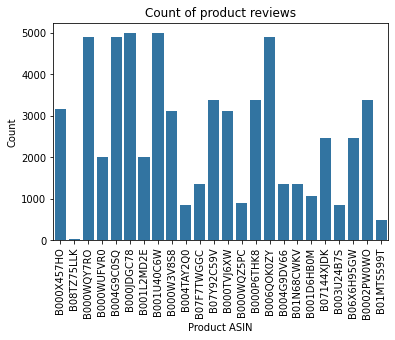

In [11]:
ax = sns.countplot(data=df, x="product_asin", color=sns.color_palette()[0])
ax.set(title="Count of product reviews", xlabel="Product ASIN", ylabel="Count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


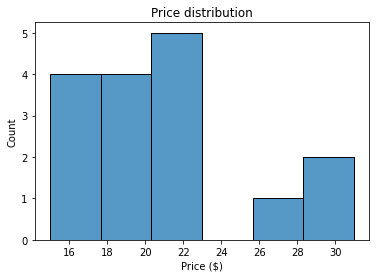

In [12]:
ax=sns.histplot(data=df["product_price"].unique())
ax.set(title="Price distribution", xlabel="Price ($)", ylabel="Count");

In [13]:
def translate(b:bool)->str:
    return "Yes" if b else "No"

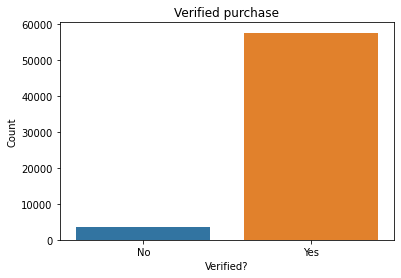

In [14]:
ax = sns.countplot(data=df, x="review_verified")
ax.set(title="Verified purchase", xlabel="Verified?", ylabel="Count")
ax.set_xticklabels(["Yes" if l.get_text()=="True" else "No" for l in list(ax.get_xticklabels())]);

The distribution of the reviews with a verified purchase is also very typical of Amazon.com products.

In [15]:
df["review_is_helpful"] = df["review_helpful_vote"].apply(lambda x : x > 0)


To study the helpful vote distribution we transform the feature to categorical (the majority of reviews are NOT helpful)

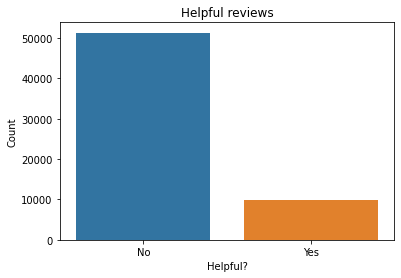

In [16]:
ax = sns.countplot(data=df, x="review_is_helpful")
ax.set(title="Helpful reviews", xlabel="Helpful?", ylabel="Count")
ax.set_xticklabels(["Yes" if l.get_text() == "True" else "No" for l in list(ax.get_xticklabels())]);

Only approximately the 17% of reviews are voted as helpful but the clients

# EDA of the Text features

Import the NLP library with a pre-trained NLP model. For the use we are intereseted in we can avoid loading in the SpaCy pipeline the `EntityRecognizer`

In [17]:
import spacy
nlp = spacy.load("en_core_web_md", exclude=["ner"])

2022-02-24 20:51:13.791419: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-24 20:51:13.791516: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
def explore(doc):
    for t in doc:
        print(t, t.dep_, t.pos_, [c for c in t.children], t.head)


In [19]:
from SentimentAnalysis.aspect_estraction import rules

In [20]:
sample_reviews = df.sample(15, random_state=42)

In [21]:
for doc in nlp.pipe(sample_reviews["review_content"]):
    print(doc)
    for sentence in doc.sents:
        for name, rule in rules.items():
            if aspect:= rule(sentence) : print(aspect)


This candle has NO SCENT at all. The worst candle I have ever purchased. I'm never buying a Yankee candle again. First time purchase by this brand, and the last.
<Aspect - candle | Modifier - NO SCENT | Rule 2>
<Aspect - candle | Modifier - worst | Rule 1>
Love love the smell
<Aspect - Love | Modifier - smell | Rule 2>
Very pleased with this scent!  Not too powerful either.  I actually don't burn them I put them in a candle warmer.  Very, very pleased!
<Aspect - scent | Modifier - pleased | Rule 8>
It does not burn evenly and just burns a hole down the center of the candle making it useless after 5 or 6 uses.
The price was amazing compared to BBB.  I couldn’t believe Amazon was selling it for the that it was.  I will be going to Amazon for Yankee candles from now on.
<Aspect - price | Modifier - amazing | Rule 3>
Smells really good
<Aspect - Smells | Modifier - good | Rule 3>
I brought it because I thought it would make my house smell like a Christmas tree but the smell is very dull an

# Negative reviews

In [ ]:
# Negative reviews

In [ ]:
nrev = df.query("review_rating<3")

In [ ]:
nrev

In [ ]:
def find_smell(review)->bool:
    return any(x in str(review).lower() for x in ('scent', 'smell', 'odor'))


In [ ]:
smell = nrev[nrev["review_content"].apply(
    find_smell) | nrev["review_title"].apply(find_smell)].copy()


In [ ]:
smell.info()

In [ ]:
smell['review_date'] = pd.to_datetime(smell['review_date'])


In [ ]:
smellw=smell.groupby(pd.Grouper(key='review_date', freq='W')).count()


In [ ]:
smellt=smellw[smellw.index.year >2015]


In [ ]:
sns.lineplot(x=smellw.index, y=smellw['review_rating'])


In [ ]:
sns.lineplot(x=smellw.index, y=smellw['review_rating'])


In [ ]:
miny = smell['review_date'].min().year
maxy = smell['review_date'].max().year


In [ ]:
maxy

In [ ]:
tmp = []
for year in range(2016,2022):
        tempdf = smellw[(smellw.index.year == year)]
        tot = tempdf['review_rating'].sum()
        tmp.append(tempdf['review_rating']/tot)



In [ ]:
tmpsmell=pd.concat(tmp,axis="rows")

In [ ]:
sns.lineplot(x=tmpsmell.index, y=tmpsmell)


In [ ]:
tmpsmell2=tmpsmell.rolling(window=7).mean()


In [ ]:
sns.lineplot(x=tmpsmell2.index, y=tmpsmell2)
